# Depth Estimation

In [ ]:
%load_ext tensorboard

import os
import time
import math
import datetime
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import models as models
import ops.depth_estimation.datasets as datasets
import ops.depth_estimation.trains as trains
import ops.depth_estimation.tests as tests

In [ ]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['mathtext.fontset'] = 'dejavuserif'
plt.rcParams['figure.figsize'] = (4, 4)
plt.rcParams['font.size'] = 15
plt.rcParams['figure.titlesize'] = 25
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['legend.fontsize'] = 13
plt.rcParams['lines.linewidth'] = 2

In [ ]:
# Paths
cwd = os.getcwd()
model_path = 'models_checkpoints'
dat_path = 'leaderboard/depth-estimation'

# NYU Depth V2
dataset_name = 'nyu_depth_v2'
img_size = 480 // 2, 640 // 2
crop_size = 480 // 2 - 30, 640 // 2 - 60
# dataset_root = ...
# seq_root = ...


In [ ]:
dataset_train, dataset_val, _ = datasets.dataset(img_size, crop_size, flip=True)

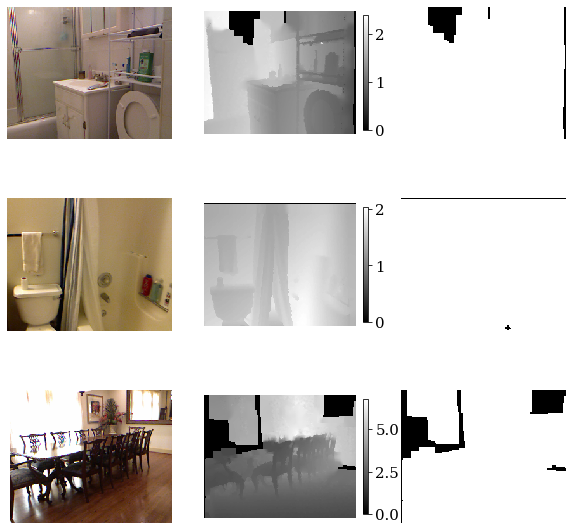

In [5]:
for xs, ys in dataset_train.skip(0).batch(3).take(1):
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    for i in range(3):
        _ = axes[i][0].imshow(xs[i])
        axes[i][0].axis('off')
        
        im = axes[i][1].imshow(tf.squeeze(ys, axis=-1)[i], cmap='gray', vmin=0)
        axes[i][1].axis('off')
        fig.colorbar(im, ax=axes[i][1], fraction=0.035, pad=0.04)
        
        y_min, y_max = 0.0, tf.reduce_max(ys, axis=[1, 2], keepdims=True)
        mask = tf.math.logical_and(ys > y_min, ys < y_max)
        axes[i][2].imshow(tf.squeeze(mask, axis=-1)[i], cmap='gray', vmin=0, vmax=1)
        axes[i][2].axis('off')


In [13]:
# DNN
# model = models.UNet(1, name='u-net-dnn')
# model = models.SegNet(1, name='segnet-dnn')

# BNN
model = models.UNet(1, rate=0.5, name='u-net-bnn')
# model = models.SegNet(1, rate=0.5, name='segnet-bnn')

model.load_weights('%s/%s_%s' % (model_path, dataset_name, model.name)) 


In [7]:
current_time = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
log_dir = 'logs/gradient_tape/%s_%s/%s' % (dataset_name, model.name, current_time)
train_log_dir = '%s/train' % log_dir
test_log_dir = '%s/test' % log_dir
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
test_summary_writer = tf.summary.create_file_writer(test_log_dir)
    
print('Create TensorBoard Log dir: ', log_dir)

## Train

In [ ]:
epochs = 5
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3, beta_1=0.9, beta_2=0.999)

epochtime_metric = tf.keras.metrics.Mean(name='epoch_time')
loss_metric = tf.keras.metrics.Mean(name='train_loss')
mse_metric = tf.keras.metrics.Mean(name='train_mse')
nll_metric = tf.keras.metrics.Mean(name='train_nll')

for epoch in range(epochs):
    batch_time = time.time()
    loss, nll, mse = trains.train_epoch(optimizer, model, dataset_train, batch_size=10)
    epochtime_metric(time.time() - batch_time)
    loss_metric(loss)
    mse_metric(mse)
    
    if (epoch + 1) % 1 == 0:
        template = '(%.2f sec) Epoch: %d, Loss: %.4f, MSE: %.4f'
        print(template % (epochtime_metric.result(),
                          epoch,
                          loss_metric.result(),
                          mse_metric.result()))
        
        with train_summary_writer.as_default():
            tf.summary.scalar('loss', loss_metric.result(), step=epoch)
            tf.summary.scalar('mse', mse_metric.result(), step=epoch)
        
        epochtime_metric.reset_states()
        loss_metric.reset_states()
        mse_metric.reset_states()

    if (epoch + 1) % 1 == 0:
        metrics = tests.test_vanilla(model,
                                     dataset_val, batch_size=10, 
                                     cutoffs=(0.0, 0.9), verbose=False)
        
        with test_summary_writer.as_default():
            tf.summary.scalar('nll', metrics[0], step=epoch)
            tf.summary.scalar('mse', metrics[1], step=epoch)


In [ ]:
model.save_weights('%s/%s_%s' % (model_path, dataset_name, model.name))

## Test

In [8]:
metrics = tests.test_vanilla(model,
                             dataset_val, batch_size=10, 
                             var=0.5, cutoffs=(0.0, 0.9), verbose=True)

10 Steps, Time: 658.052 ± 1406.358 ms, NLL: 1.1799, RMSE: 0.779, Abs Rel: 0.265, Sq Rel: 0.254, 𝛿1: 0.598, 𝛿2: 0.872, 𝛿3: 0.955
20 Steps, Time: 421.244 ± 1022.273 ms, NLL: 1.3618, RMSE: 0.889, Abs Rel: 0.275, Sq Rel: 0.291, 𝛿1: 0.583, 𝛿2: 0.857, 𝛿3: 0.949
30 Steps, Time: 344.432 ± 841.729 ms, NLL: 1.3518, RMSE: 0.883, Abs Rel: 0.276, Sq Rel: 0.295, 𝛿1: 0.584, 𝛿2: 0.857, 𝛿3: 0.948
40 Steps, Time: 305.596 ± 732.060 ms, NLL: 1.3492, RMSE: 0.881, Abs Rel: 0.276, Sq Rel: 0.294, 𝛿1: 0.585, 𝛿2: 0.859, 𝛿3: 0.949
50 Steps, Time: 282.002 ± 656.472 ms, NLL: 1.3401, RMSE: 0.876, Abs Rel: 0.280, Sq Rel: 0.298, 𝛿1: 0.578, 𝛿2: 0.853, 𝛿3: 0.947
60 Steps, Time: 265.747 ± 600.381 ms, NLL: 1.3293, RMSE: 0.870, Abs Rel: 0.279, Sq Rel: 0.296, 𝛿1: 0.580, 𝛿2: 0.855, 𝛿3: 0.948
Time: 267.408 ± 576.383 ms, NLL: 1.3237, RMSE: 0.867, Abs Rel: 0.277, Sq Rel: 0.292, 𝛿1: 0.580, 𝛿2: 0.857, 𝛿3: 0.950


In [ ]:
metrics = test_sampling(model, 30, 
                        dataset_val, batch_size=10, 
                        var=0.5, cutoffs=(0.0, 0.9), verbose=True)

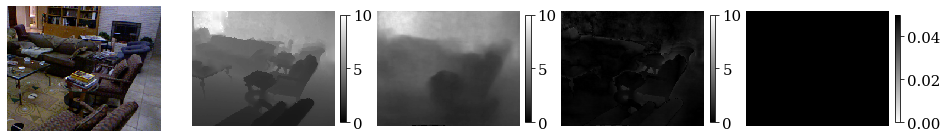

In [22]:
for xs, ys in dataset_train.skip(10).batch(1).take(1):
    ys_pred = tests.predict_vanilla(model, xs, var=0.05)
    ys_pred_mean, ys_pred_var = tf.split(ys_pred, [1, 1], axis=-1)
    
    mse = tf.math.square(ys_pred_mean - ys)
    rmse = tf.math.sqrt(mse)
        
    fig, axes = plt.subplots(1, 5, figsize=(16, 5))
    axes[0].imshow(xs[0])
    im = axes[1].imshow(tf.squeeze(ys, axis=-1)[0], vmin=0, vmax=tf.reduce_max(ys[0]), cmap='gist_gray')
    fig.colorbar(im, ax=axes[1], fraction=0.035, pad=0.04)
    im = axes[2].imshow(tf.squeeze(ys_pred_mean, axis=-1)[0], vmin=0, vmax=tf.reduce_max(ys[0]), cmap='gist_gray')
    fig.colorbar(im, ax=axes[2], fraction=0.035, pad=0.04)
    im = axes[3].imshow(tf.squeeze(rmse, axis=-1)[0], vmin=0, vmax=tf.reduce_max(ys[0]), cmap='gist_gray')
    fig.colorbar(im, ax=axes[3], fraction=0.035, pad=0.04)
    im = axes[4].imshow(tf.squeeze(ys_pred_var, axis=-1)[0], vmin=0, cmap='gist_yarg')
    fig.colorbar(im, ax=axes[4], fraction=0.035, pad=0.04)
    
    for ax in axes:
        ax.axis('off')
        

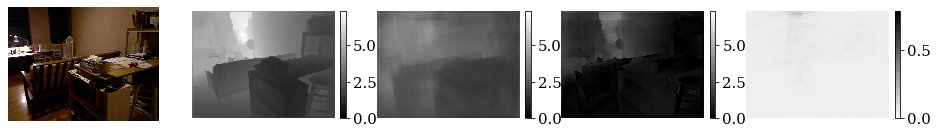

In [19]:
for xs, ys in dataset_val.skip(20).batch(1).take(1):
    ys_pred = tests.predict_sampling(model, xs, 10, var=0.05)
    ys_pred_mean, ys_pred_var = tf.split(ys_pred, [1, 1], axis=-1)
    
    mse = tf.math.square(ys_pred_mean - ys)
    rmse = tf.math.sqrt(mse)
    
    fig, axes = plt.subplots(1, 5, figsize=(16, 5))
    axes[0].imshow(xs[0])
    im = axes[1].imshow(tf.squeeze(ys, axis=-1)[0], vmin=0, vmax=tf.reduce_max(ys[0]), cmap='gist_gray')
    fig.colorbar(im, ax=axes[1], fraction=0.035, pad=0.04)
    im = axes[2].imshow(tf.squeeze(ys_pred_mean, axis=-1)[0], vmin=0, vmax=tf.reduce_max(ys[0]), cmap='gist_gray')
    fig.colorbar(im, ax=axes[2], fraction=0.035, pad=0.04)
    im = axes[3].imshow(tf.squeeze(rmse, axis=-1)[0], vmin=0, vmax=tf.reduce_max(ys[0]), cmap='gist_gray')
    fig.colorbar(im, ax=axes[3], fraction=0.035, pad=0.04)
    im = axes[4].imshow(tf.squeeze(ys_pred_var, axis=-1)[0], vmin=0, cmap='gist_yarg')
    fig.colorbar(im, ax=axes[4], fraction=0.035, pad=0.04)
    
    for ax in axes:
        ax.axis('off')
    